In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import sys
import requests as req
from pyquery import PyQuery
from datetime import datetime
import json
from itertools import combinations


### There is one part that is written not in Python: conversion mp3 to wav is done via Linux app called "mpg321" in function convert_mp3_to_wav. Everything else is Python.

In [2]:
def get_all_mp3s(path):
    w = os.walk(path)
    # folder / subfolders / files
    all_files = []
    for sw in w:
        all_files += [sw[0] + "/" + x for x in sw[2]]
    mp3_files = []
    for f in all_files:
        if f.split(".")[-1].upper() == "MP3": # Only taking mp3s
            mp3_files.append(f)
    return mp3_files

In [3]:
def convert_mp3_to_wav(filename_mp3, filename_wav=None):
    cd = os.getcwd() # If filename doesn't contain path, use current directory
    if "/" not in filename_mp3:
        filename_mp3 = cd + "/" + filename_mp3
    filename_wav =  ".".join(mp3_file.split(".")[0:-1]) + ".wav"
    subprocess.run(["mpg321", "-w", filename_wav, filename_mp3])
    return filename_wav

In [4]:
def get_wav_data(filepath, bucket_width=100):
    """ 
    Data of wav file is very much narrowed down to what I want to analyse. 
    So if you want to analyse in your own way, this is the function to change.
    """
    fs, data = wavfile.read(filepath)
    df_data = pd.DataFrame(data)
    df_data['max'] = df_data.max(axis=1)
    df_data['buckets'] = pd.Series(df_data['max']/bucket_width).astype(int)
    bucket_sizes = df_data.groupby('buckets').size()
    bucket_sizes = bucket_sizes.drop(bucket_sizes.idxmax())
    return (bucket_sizes/max(bucket_sizes))

In [6]:
def dump_json(path, df_data):
    "Dumping data into JSON"
    with open(path, 'w') as outfile:
        json.dump(df_data.to_json(), outfile)
    print("Data is dumped.")
    return True

#dump_json(full_data_dump_file_path, pd.DataFrame(all_data))

In [7]:
def read_json(path):
    "Reading dumps"
    with open(path, 'r') as datafile:
        loaded_data = json.loads(json.load(datafile))
    print("Loaded data for",len(all_data),"songs")
    return loaded_data

#loaded_data = read_json(full_data_dump_file_path)

In [27]:
def process_library(path, max_files=None):
    "Get aggregated wav data from the lib path"
    lib_data = {}
    process_counter = 0
    convert_counter = 0
    for mp3_file in get_all_mp3s(path):
        wav_file = (".".join(mp3_file.split(".")[0:-1]) + ".wav")
        if not os.path.isfile(wav_file):
            # I'm saving wav next to mp3, you can change it here.
            wav_file = convert_mp3_to_wav(mp3_file, wav_file)
            convert_counter+=1
        wav_data = get_wav_data(wav_file,300)
        # Can remove wav_files here!
        #os.remove(wav_file)
        lib_data[mp3_file] = wav_data
        process_counter+=1
        if (process_counter==10 or process_counter==50 or process_counter%100==0):
            print(datetime.now())
            print("Processed " + str(process_counter)
                  + " songs, converted " + str(convert_counter))
        if max_files: 
            if process_counter>=max_files: 
                break
    print("Finished! Songs processed:", len(lib_data), "Size of the data is", sys.getsizeof(lib_data)/1024, "kb.")
    return lib_data

misuc_lib_path = "/media/shad/DATA/MuzAnalysis" # Location of the library
full_data_dump_file_path = misuc_lib_path + "/Full_Data.json" # Your data dump file

# Keeping whole file paths to be able to manipulate files later
all_data = process_library(misuc_lib_path, max_files=3)


# Clean names (shorten for convinience and memory optimization), saves as a separate dataframe
# Keeping 2 data structures for experimentation convinience, feel free to use only one and remove another!
all_data_clean_dict = {k[len(misuc_lib_path):]:v for k, v in all_data.items()}
all_data_df = pd.DataFrame([(k[len(misuc_lib_path):], v) for k, v in all_data.items()])
print("Lib path is removed from file names, dictionary is converted to DataFrame")

Finished! Songs processed: 3 Size of the data is 0.234375 kb.
Lib path is removed from file names, dictionary is converted to DataFrame


# Experiment starting from here
### Everythin that follows is in very raw state

/media/shad/DATA/MuzAnalysis/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3


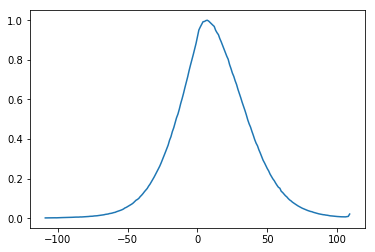

/media/shad/DATA/MuzAnalysis/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - Voices.mp3


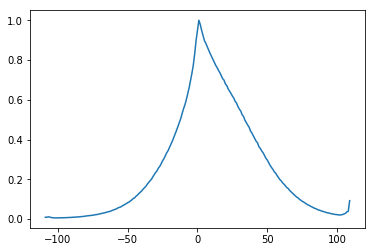

/media/shad/DATA/MuzAnalysis/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The Game.mp3


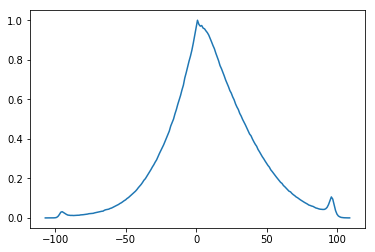

In [18]:
chart_sample = 3 # Limit sample of songs to build charts
for k, v in all_data.items():
    if chart_sample > 0:
        chart_sample-=1
        print(k)
        plt.plot(v)
        plt.show()
    else:
        break

In [35]:
def make_combinations(df):
    # Make a list of all combinations, to have list of comparisons.
    prodj = combinations(list(df[0]), 2)
    prodj = list(prodj)
    print("Number of possible comparisons:", len(list(prodj)))
    return prodj

comb = make_combinations(all_data_df)

Number of possible comparisons: 3


In [31]:
import pprint
# Check out all combination pairs
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(comb)

[   (   '/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3',
        '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - '
        'Voices.mp3'),
    (   '/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3',
        '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The '
        'Game.mp3'),
    (   '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - '
        'Voices.mp3',
        '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The '
        'Game.mp3')]


In [38]:
def compare_songs(prodj, cleaned_dect):
    print("Pairs to compare: " + str(len(prodj)))
    comparing_data = []#pd.DataFrame()
    comparing_counter = 0
    for song1_name, song2_name in prodj:
        comparing_counter+=1
        if (comparing_counter%100000==0 
            or comparing_counter==10 
            or comparing_counter==50
            or comparing_counter==100
            or comparing_counter==500
            or comparing_counter==1000
            or comparing_counter==10000
            or comparing_counter==50000
           ):
            print(str(datetime.now()) + " Compared " + str(comparing_counter) + " songs.")
        if song1_name == song2_name:
            print("Comparing to itself :(")
        result = pd.concat([
            cleaned_dect[song1_name], 
            cleaned_dect[song2_name]], 
            axis=1, join='inner').fillna(0) #join_axes=[song1_data.index]
        result['dif'] = abs(result[0] - result[1])
        #print(str(sum(result['dif'])) + " for " + song2_name)
        comparing_data.append((song1_name, song2_name, sum(result['dif'])))

    print(str(datetime.now()) + " Compared " + str(comparing_counter) + " pairs of songs.")
    print("Finished!")
    return comparing_data

# Should rewrite to use only one data structure
comp = compare_songs(make_combinations(all_data_df), all_data_clean_dict)
print("\nThe lower value, the closer genre of songs.")
comp

Number of possible comparisons: 3
Pairs to compare: 3
2019-05-02 13:11:43.223476 Compared 3 pairs of songs.
Finished!

The lower value, the closer genre of songs.


[('/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3',
  '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - Voices.mp3',
  8.79261631584778),
 ('/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3',
  '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The Game.mp3',
  7.623176410871259),
 ('/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - Voices.mp3',
  '/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The Game.mp3',
  5.358690467809089)]

In [ ]:
#keys = list(all_data_df[0])
index = all_data_df.index.union(all_data_df[0])
all_data_df = all_data_df.reindex(index=index, columns=index, fill_value=0)
print(all_data_df)

In [ ]:
import networkx as nx
G = G=nx.from_numpy_matrix(comparing_data)
nx.draw(G)

## Product join of all elements

In [ ]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)


cut_path = len(misuc_lib_path)
cd = [(c[0][cut_path:], c[1][cut_path:], c[2]) for c in comparing_data]
sizes = [c[2] for c in cd]
size_buckets = {}
for s in sizes:
    ns = int(s/10)
    if ns in size_buckets:
        size_buckets[ns] += 1
    else:
        size_buckets[ns] = 1

pp.pprint(size_buckets)

In [ ]:
len(top_simil)
top_simil.to_csv(index=True, path_or_buf=(misuc_lib_path + "/Comparing.csv"))

# Web parser

In [ ]:

r = req.get('https://lyrics.fandom.com/wiki/3_Doors_Down')


In [ ]:
print(r.content)

In [ ]:
# Getting ganres
b1 = bands[0]
url = "https://lyrics.fandom.com/wiki/" + "_".join(b1.split(" "))
r = req.get(url)
print(r.content)

In [ ]:
# Parsing out ganres
pq = PyQuery(r.content)
print(pq)

</div></div><div class="css-table-cell">
<p class="highlight"><b>Genres:</b></p><div>
<ul><li><a href="/wiki/Category:Genre/Alternative_Rock" title="Category:Genre/Alternative Rock">Alternative Rock</a>
</li><li><a href="/wiki/Category:Genre/Pop_Rock" title="Category:Genre/Pop Rock">Pop Rock</a>
</li><li><a href="/wiki/Category:Genre/Post-Grunge" title="Category:Genre/Post-Grunge">Post-Grunge</a>
</li></ul>
</div>